In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
from sklearn.preprocessing import normalize
from tensorflow.keras.regularizers import l2
from data_preprocessing import *
from model import *

In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
stopword_list = get_stopwords("../marathi-stopwords.txt")

In [5]:
x_train = training_data.text.apply(lambda x: preprocess_data(stopword_list, x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: preprocess_data(stopword_list, x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [6]:
y_train, y_val = label_encoder(y_train, y_val)

In [7]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [8]:
pad_len=100
padding_type='post'
truncating_type='post'

In [9]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(x_train, x_val)

In [10]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [ ]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

In [11]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [12]:
vocab = tokenizer.word_index

In [14]:
start = process_time()
embedding_path = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.indic.ds.cleaned.conc.600.vec"
embedding_matrix = get_embedding_matrix(embedding_path, vocab, embedding_dim=600)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix.shape

29154
Total time taken:  4.393797521


(51802, 600)

In [15]:
input_dim = embedding_matrix.shape[0]
embedding_dim = 600
input_len = pad_len
print("Input vocab: ", input_dim)
print("Embedding dimensions: ", embedding_dim)
print("Input sentence dimensions: ", input_len)

Input vocab:  51802
Embedding dimensions:  600
Input sentence dimensions:  100


In [16]:
myCB = myCallbacks(metrics='acc', threshold=0.97)

# Feed-Forward Neural Network Model

In [17]:
myDNN = create_model_DNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix, 
                         input_len, 
                         trainable=False, 
                         n1=64, n2=32, 
                         kr=l2(0.0))
myDNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 600)          31081200  
_________________________________________________________________
global_max_pooling1d (Global (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                38464     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 31,121,876
Trainable params: 40,676
Non-trainable params: 31,081,200
_________________________________________________________________


In [18]:
history1 = myDNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val),
                    callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 11s 9ms/step - loss: 0.7154 - acc: 0.7279 - val_loss: 0.5768 - val_acc: 0.7812
Epoch 2/8
1313/1313 [==============================] - 12s 9ms/step - loss: 0.5741 - acc: 0.7845 - val_loss: 0.5922 - val_acc: 0.7701
Epoch 3/8
1313/1313 [==============================] - 12s 9ms/step - loss: 0.5568 - acc: 0.7894 - val_loss: 0.6035 - val_acc: 0.7606
Epoch 4/8
1313/1313 [==============================] - 15s 11ms/step - loss: 0.5430 - acc: 0.7938 - val_loss: 0.6325 - val_acc: 0.7672
Epoch 5/8
1313/1313 [==============================] - 12s 9ms/step - loss: 0.5346 - acc: 0.7970 - val_loss: 0.5701 - val_acc: 0.7823
Epoch 6/8
1313/1313 [==============================] - 13s 10ms/step - loss: 0.5287 - acc: 0.8004 - val_loss: 0.5622 - val_acc: 0.7878
Epoch 7/8
1313/1313 [==============================] - 14s 11ms/step - loss: 0.5197 - acc: 0.8031 - val_loss: 0.5816 - val_acc: 0.7783
Epoch 8/8
1313/1313 [==============================] - 15s 

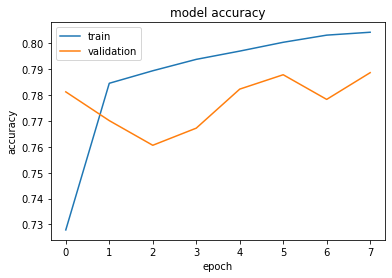

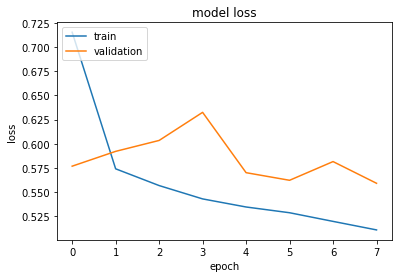

In [19]:
plot_curves(history1)

In [ ]:
name = "FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585"
myDNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myDNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myDNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myDNN = model_load("../models/FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585.h5")

In [20]:
results1 = np.argmax(myDNN.predict(x_val_padded), axis=-1)

In [21]:
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.7886243386243387

Precision:  [0.93117409 0.79490367 0.77926421 0.7526777 ]
Average Precision:  0.8145049180085685

Recall:  [0.54761905 0.84983389 0.78983051 0.79690722]
Average nRecall:  0.7460476649079146

F1-Score:  [0.68965517 0.82145151 0.78451178 0.77416124]
Average F1-Score:  0.7674449270252882


# CNN Model

In [23]:
myCNN = create_model_CNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix, 
                         input_len, 
                         trainable=False, 
                         n1=64, k=5, 
                         d=0.25, kr=l2(0.0))
myCNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 600)          31081200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            192064    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
Total params: 31,273,524
Trainable params: 192,324
Non-trainable params: 31,081,200
_________________________________________________________________


In [24]:
history2 = myCNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val),
                     callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 84s 64ms/step - loss: 0.5298 - acc: 0.8012 - val_loss: 0.4333 - val_acc: 0.8378
Epoch 2/8
1313/1313 [==============================] - 89s 68ms/step - loss: 0.3766 - acc: 0.8606 - val_loss: 0.4550 - val_acc: 0.8275
Epoch 3/8
1313/1313 [==============================] - 94s 71ms/step - loss: 0.2992 - acc: 0.8896 - val_loss: 0.4336 - val_acc: 0.8376
Epoch 4/8
 701/1313 [===============>..............] - ETA: 39s - loss: 0.2342 - acc: 0.9118

KeyboardInterrupt: 

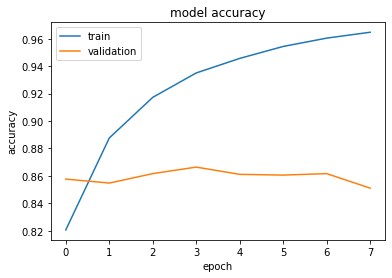

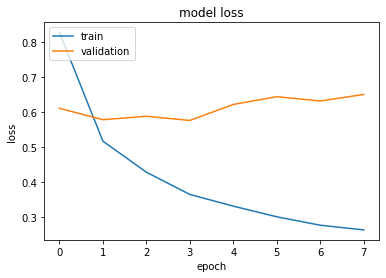

In [25]:
plot_curves(history2)

In [ ]:
name ="CNN/CNN-n1.64n2.64-kr0015-vacc8632"
myCNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myCNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myCNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myCNN = model_load("../models/CNN/CNN-n1.64n2.64-kr0015-vacc8632.h5")

In [26]:
results2 = np.argmax(myCNN.predict(x_val_padded), axis=-1)

In [27]:
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8510582010582011

Precision:  [0.82552083 0.8595913  0.86971429 0.83167331]
Average Precision:  0.846624931109054

Recall:  [0.7547619  0.86644518 0.85988701 0.86082474]
Average nRecall:  0.835479708850979

F1-Score:  [0.78855721 0.86300463 0.86477273 0.84599797]
Average F1-Score:  0.840583136888551


# Bi-LSTM Model

In [29]:
myLSTM = create_model_LSTM(input_dim, 
                           embedding_dim, 
                           embedding_matrix, 
                           input_len, 
                           trainable=False, 
                           n1=64, n2=64, 
                           d=0.3)
myLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          15540600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          186880    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 15,735,996
Trainable params: 15,735,996
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3 = myLSTM.fit(x_train_padded, 
                      y_train, 
                      epochs=8, 
                      batch_size=32, 
                      verbose=1, 
                      validation_data = (x_val_padded, y_val), 
                      callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 523s 398ms/step - loss: 0.4316 - acc: 0.8408 - val_loss: 0.3252 - val_acc: 0.8815
Epoch 2/8
1313/1313 [==============================] - 481s 366ms/step - loss: 0.2422 - acc: 0.9124 - val_loss: 0.3366 - val_acc: 0.8754
Epoch 3/8
1313/1313 [==============================] - 449s 342ms/step - loss: 0.1556 - acc: 0.9437 - val_loss: 0.3573 - val_acc: 0.8749
Epoch 4/8
 903/1313 [===================>..........] - ETA: 2:39 - loss: 0.1024 - acc: 0.9618

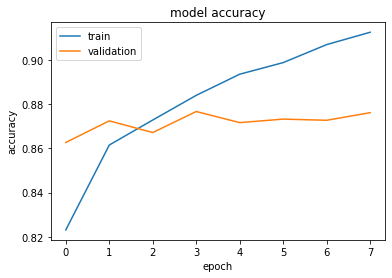

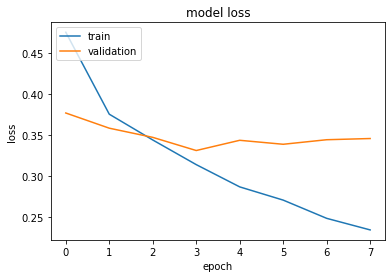

In [38]:
plot_curves(history3)

In [41]:
name= "LSTM/Bi-LST-n1.64-n2.64-d30-f1-8674"
myLSTM.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myLSTM.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myLSTM.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myLSTM = model_load("../models/LSTM/Bi-LST-n1.64-n2.64-kr0015-vacc868.h5")

In [39]:
results3 = np.argmax(myLSTM.predict(x_val_padded), axis=-1)

In [40]:
acc, precision, recall, f1 = classification_report(y_val, results3)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8761904761904762

Precision:  [0.92173913 0.84241706 0.92892157 0.87432868]
Average Precision:  0.8918516098783913

Recall:  [0.75714286 0.9448505  0.85649718 0.83917526]
Average nRecall:  0.8494164470887323

F1-Score:  [0.83137255 0.8906984  0.89124045 0.85639137]
Average F1-Score:  0.8674256928833096
